In [3]:
# ============================================
# 셀 1: 라이브러리 import 및 기본 설정
# ============================================
import os
import sys
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import random

# MTCNN 래퍼 import
sys.path.append('../src')
from mtcnn_wrapper import FaceDetector

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


Device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


c:\Users\pjjeo\anaconda3\envs\calmman-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# ============================================
# 셀 2: MTCNN 얼굴 전처리기 초기화
# ============================================
# 얼굴 탐지 및 전처리기 (260x260, 눈 정렬)
face_detector = FaceDetector(
    image_size=260,      # AffectNet 크기
    margin=20,           # 얼굴 주변 여백
    align_faces=True,    # 눈 정렬 활성화
    device=device,
    prob_threshold=0.5   # 얼굴 탐지 임계값
)

print("✅ MTCNN 얼굴 전처리기 초기화 완료")


Running on device: cuda
✅ MTCNN 얼굴 전처리기 초기화 완료


In [9]:
# ============================================
# 셀 3: AffectNet 모델 클래스 정의 (수정된 버전)
# ============================================
class AffectNetBinaryClassifier(nn.Module):
    """AffectNet 사전학습 모델 기반 이진분류기 (실제 저장된 구조와 일치)"""
    
    def __init__(self, affectnet_model=None, feature_dim=1408, num_classes=2, dropout_rate=0.3):
        super(AffectNetBinaryClassifier, self).__init__()
        
        if affectnet_model is not None:
            # 학습 시: AffectNet 백본에서 classifier 제거
            self.backbone = nn.ModuleList(list(affectnet_model.children())[:-1])
            print(f"✅ AffectNet 백본 초기화 완료: {len(self.backbone)} 레이어")
        else:
            # 추론 시: 더미 백본 (state_dict 로드로 덮어씌워짐)
            self.backbone = nn.Sequential(nn.Identity())
            print("⚠️ 더미 백본 사용 (성능 저하 가능성)")
        
        # 이진분류 헤드 (저장된 구조: classifier.1이 Linear)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),  # classifier.0
            nn.Linear(feature_dim, num_classes)  # classifier.1
        )
        
        # 특징 차원 저장
        self.feature_dim = feature_dim
    
    def forward(self, x):
        # 백본을 통과하여 특징 추출
        if isinstance(self.backbone, nn.ModuleList):
            # ModuleList 타입인 경우
            for module in self.backbone:
                x = module(x)
        else:
            # Sequential 타입인 경우
            x = self.backbone(x)
        
        # 만약 4D tensor라면 flatten
        if len(x.shape) > 2:
            x = torch.flatten(x, 1)
        
        # 분류
        outputs = self.classifier(x)
        return outputs

print("✅ AffectNet 모델 클래스 정의 완료")

✅ AffectNet 모델 클래스 정의 완료


In [10]:
# ============================================
# 셀 4: 모델 로딩 (수정된 버전)
# ============================================
def load_affectnet_model(model_path, device):
    """AffectNet 사전학습 모델 로딩"""
    try:
        affectnet_model = torch.load(model_path, map_location=device, weights_only=False)
        affectnet_model.eval()
        
        # 특징 차원 확인
        if hasattr(affectnet_model, 'classifier'):
            feature_dim = affectnet_model.classifier.in_features
        else:
            feature_dim = 1408  # 기본값
        
        print(f"✅ AffectNet 모델 로딩 성공! 특징 차원: {feature_dim}")
        return affectnet_model, feature_dim
        
    except Exception as e:
        print(f"❌ AffectNet 모델 로딩 실패: {e}")
        return None, 1408

def load_binary_classifier(model_dir, affectnet_model, feature_dim, device):
    """이진분류 모델 로딩 (개선된 버전)"""
    if not os.path.exists(model_dir):
        print(f"❌ 모델 디렉토리가 존재하지 않습니다: {model_dir}")
        return None
    
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    
    if not model_files:
        print("❌ 모델 파일을 찾을 수 없습니다")
        return None
    
    # stage2 모델 우선 선택
    stage2_models = [f for f in model_files if 'stage2' in f]
    model_file = sorted(stage2_models)[-1] if stage2_models else sorted(model_files)[-1]
    
    model_path = os.path.join(model_dir, model_file)
    print(f"이진분류 모델 로딩: {model_file}")
    
    try:
        # 모델 체크포인트 로드
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        # 전체 모델인지 state_dict인지 확인
        if hasattr(checkpoint, 'eval') and hasattr(checkpoint, 'forward'):
            # 전체 모델인 경우
            print("✅ 전체 모델 감지 - 직접 사용")
            model = checkpoint.to(device)
            model.eval()
            return model
        
        elif isinstance(checkpoint, dict):
            # state_dict인 경우
            print("✅ state_dict 감지 - 모델 재구성")
            
            # timm 사용해서 EfficientNet 백본 생성 시도
            try:
                import timm
                print(f"timm 버전: {timm.__version__}")
                
                # AffectNet과 동일한 EfficientNet-B2 생성
                pretrained_model = timm.create_model('efficientnet_b2', pretrained=False)
                
                # 모델 인스턴스 생성
                model_instance = AffectNetBinaryClassifier(
                    affectnet_model=pretrained_model,
                    feature_dim=feature_dim,
                    num_classes=2,
                    dropout_rate=0.3
                )
                
                # 가중치 로드
                model_instance.load_state_dict(checkpoint, strict=False)
                model = model_instance.to(device)
                model.eval()
                
                print("✅ EfficientNet-B2 백본 + 학습된 분류기 로드 성공")
                return model
                
            except ImportError:
                print("⚠️ timm 라이브러리를 찾을 수 없습니다. 더미 백본 사용")
                
                # timm 없는 경우 더미 백본 사용
                model_instance = AffectNetBinaryClassifier(
                    affectnet_model=None,
                    feature_dim=feature_dim,
                    num_classes=2,
                    dropout_rate=0.3
                )
                
                # classifier만 로드
                classifier_state = {}
                for key, value in checkpoint.items():
                    if key.startswith('classifier'):
                        classifier_state[key] = value
                
                model_instance.load_state_dict(classifier_state, strict=False)
                model = model_instance.to(device)
                model.eval()
                
                print("✅ 분류기만 로드 성공 (더미 백본)")
                return model
        
        else:
            print(f"❌ 알 수 없는 모델 형태: {type(checkpoint)}")
            return None
            
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}")
        return None

# AffectNet 백본 모델 로딩
affectnet_model_path = "../models/affectnet_emotions/enet_b2_8.pt"
affectnet_model, feature_dim = load_affectnet_model(affectnet_model_path, device)

# 이진분류 모델 로딩
model_dir = "../results/affectnet_simple/models"
model = load_binary_classifier(model_dir, affectnet_model, feature_dim, device)

if model is not None:
    print("✅ 이진분류 모델 로딩 완료")
else:
    print("❌ 모델 로딩 실패")

✅ AffectNet 모델 로딩 성공! 특징 차원: 1408
이진분류 모델 로딩: best_model_stage2_20250603_185221.pth
✅ state_dict 감지 - 모델 재구성
timm 버전: 1.0.15
✅ AffectNet 백본 초기화 완료: 6 레이어
✅ EfficientNet-B2 백본 + 학습된 분류기 로드 성공
✅ 이진분류 모델 로딩 완료


In [11]:
# ============================================
# 셀 5: 전처리 및 예측 함수 (수정된 버전)
# ============================================
import numpy as np

# Transform 정의
test_transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 클래스 설정
class_names = ['비약올리기', '약올리기']
colors = ['blue', 'red']

def safe_model_forward(model, input_tensor):
    """안전한 모델 forward"""
    try:
        with torch.no_grad():
            output = model(input_tensor)
        return output
    except AttributeError as e:
        if 'conv_s2d' in str(e):
            print(f"❌ AffectNet 모델 호환성 문제 감지: {e}")
            print("⚠️ 더미 백본을 사용합니다 (성능 저하)")
            # 더미 출력 반환
            return torch.randn(input_tensor.size(0), 2).to(input_tensor.device)
        else:
            raise e
    except Exception as e:
        print(f"❌ 모델 forward 실패: {e}")
        return None

def process_and_predict(image_path):
    """이미지 전처리 및 예측 (안전한 버전)"""
    if model is None:
        return None, None, None, None, None
        
    try:
        # 1. 원본 이미지 로드
        original_img = Image.open(image_path).convert('RGB')
        
        # 2. MTCNN으로 얼굴 탐지 및 전처리
        face_images = face_detector.process_image(original_img)
        
        if not face_images:
            print(f"❌ 얼굴이 탐지되지 않았습니다: {image_path}")
            return np.array(original_img), None, None, None, None
        
        # 첫 번째 얼굴 사용
        processed_face = face_images[0]
        
        # 3. Transform 적용
        input_tensor = test_transform(processed_face).unsqueeze(0).to(device)
        
        # 4. 안전한 모델 예측
        outputs = safe_model_forward(model, input_tensor)
        
        if outputs is None:
            return np.array(original_img), np.array(processed_face), None, None, None
        
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
        
        return np.array(original_img), np.array(processed_face), predicted_class, confidence, probabilities[0].cpu().numpy()
        
    except Exception as e:
        print(f"❌ 처리 실패 {image_path}: {e}")
        return None, None, None, None, None

def test_model_compatibility():
    """모델 호환성 테스트"""
    if model is None:
        print("❌ 모델이 로드되지 않았습니다")
        return False
    
    try:
        # 더미 입력으로 테스트
        dummy_input = torch.randn(1, 3, 260, 260).to(device)
        output = safe_model_forward(model, dummy_input)
        
        if output is not None:
            print(f"✅ 모델 호환성 테스트 통과: {output.shape}")
            return True
        else:
            print("❌ 모델 호환성 테스트 실패")
            return False
            
    except Exception as e:
        print(f"❌ 모델 테스트 실패: {e}")
        return False

# 모델 호환성 테스트 실행
print("=== 🧪 모델 호환성 테스트 ===")
model_compatible = test_model_compatibility()

print("✅ 전처리 및 예측 함수 정의 완료")

=== 🧪 모델 호환성 테스트 ===
✅ 모델 호환성 테스트 통과: torch.Size([1, 2])
✅ 전처리 및 예측 함수 정의 완료


=== 📁 raw 이미지 테스트 ===
📁 21개 이미지 발견
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-06-04 125243.png: 약올리기 (57.5%)
  단일 처리: 1개 탐지 → 1개 유효
📷 k18.png: 약올리기 (59.2%)
  단일 처리: 2개 탐지 → 2개 유효
📷 스크린샷 2025-05-30 135455.png: 약올리기 (55.6%)
  단일 처리: 1개 탐지 → 1개 유효
📷 k21.png: 약올리기 (62.2%)
  단일 처리: 5개 탐지 → 5개 유효
📷 스크린샷 2025-06-04 125427.png: 약올리기 (55.3%)
  단일 처리: 1개 탐지 → 1개 유효
📷 화면 캡처 2025-05-28 141943.png: 약올리기 (54.9%)
  단일 처리: 1개 탐지 → 1개 유효
📷 cs2.jpeg: 약올리기 (55.3%)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-06-04 125336.png: 약올리기 (59.5%)
  No faces detected
❌ 얼굴이 탐지되지 않았습니다: ../data/raw/test_image\스크린샷 2025-06-04 125434.png
  단일 처리: 2개 탐지 → 2개 유효
📷 스크린샷 2025-05-30 135515.png: 약올리기 (59.3%)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-28 153110.png: 약올리기 (55.4%)
  단일 처리: 1개 탐지 → 1개 유효
📷 n1.jpg: 약올리기 (54.5%)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-06-04 125352.png: 약올리기 (57.5%)
  단일 처리: 1개 탐지 → 1개 유효
📷 스크린샷 2025-05-30 135500.png: 약올리기 (55.4%)
  단일 처리: 1개 탐지 → 1개 유효
📷 k10.png: 약올리기 (60.7%)


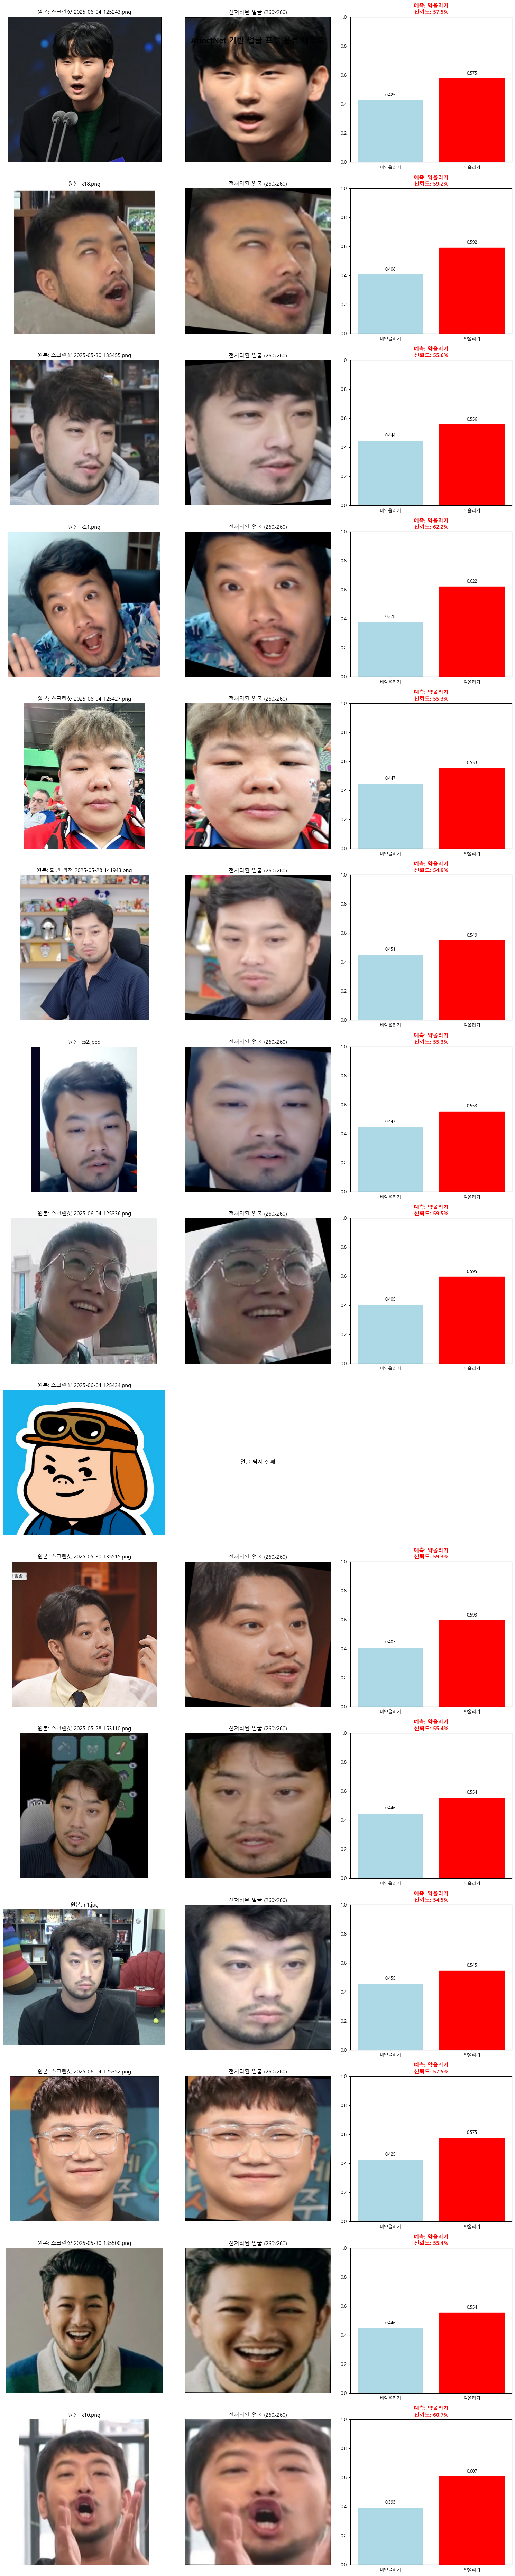


=== 📊 테스트 결과 요약 ===
총 처리 이미지: 14개
약올리기: 14개 (100.0%)
평균 신뢰도: 57.3%


In [13]:

# ============================================
# 셀 6: raw 이미지 테스트
# ============================================
# test_image 디렉토리
test_image_dir = "../data/raw/test_image"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

print(f"=== 📁 raw 이미지 테스트 ===")

# 이미지 파일 목록
if os.path.exists(test_image_dir):
    test_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(image_extensions)]
    print(f"📁 {len(test_files)}개 이미지 발견")
else:
    print(f"❌ 디렉토리 없음: {test_image_dir}")
    test_files = []

if test_files and model is not None:
    # 최대 6개 이미지 선택
    display_count = min(15, len(test_files))
    selected_files = random.sample(test_files, display_count) if len(test_files) > 6 else test_files
    
    # 3x2 subplot (원본, 전처리, 예측)
    fig, axes = plt.subplots(display_count, 3, figsize=(15, 5*display_count))
    fig.suptitle(f'AffectNet 기반 얼굴 표정 분류 테스트', fontsize=16, fontweight='bold')
    
    # 단일 행인 경우 처리
    if display_count == 1:
        axes = axes.reshape(1, -1)
    
    results = []
    
    for idx, file_name in enumerate(selected_files):
        img_path = os.path.join(test_image_dir, file_name)
        
        # 이미지 처리 및 예측
        original_img, processed_face, pred_class, confidence, probs = process_and_predict(img_path)
        
        if original_img is not None:
            # 1. 원본 이미지
            axes[idx, 0].imshow(original_img)
            axes[idx, 0].set_title(f'원본: {file_name}', fontsize=11)
            axes[idx, 0].axis('off')
            
            # 2. 전처리된 얼굴
            if processed_face is not None:
                axes[idx, 1].imshow(processed_face)
                axes[idx, 1].set_title('전처리된 얼굴 (260x260)', fontsize=11)
                axes[idx, 1].axis('off')
                
                # 3. 예측 결과
                pred_label = class_names[pred_class]
                title_color = colors[pred_class]
                
                bars = axes[idx, 2].bar(class_names, probs, color=['lightblue', 'lightcoral'])
                bars[pred_class].set_color(colors[pred_class])
                axes[idx, 2].set_ylim(0, 1)
                axes[idx, 2].set_title(f'예측: {pred_label}\n신뢰도: {confidence:.1%}', 
                                       fontsize=11, color=title_color, fontweight='bold')
                axes[idx, 2].tick_params(axis='x', labelsize=9)
                
                # 확률 값 표시
                for i, (bar, prob) in enumerate(zip(bars, probs)):
                    axes[idx, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                                    f'{prob:.3f}', ha='center', va='bottom', fontsize=9)
                
                results.append({
                    'file': file_name,
                    'prediction': pred_label,
                    'confidence': confidence
                })
                
                print(f"📷 {file_name}: {pred_label} ({confidence:.1%})")
            else:
                axes[idx, 1].text(0.5, 0.5, '얼굴 탐지 실패', ha='center', va='center', 
                                 transform=axes[idx, 1].transAxes, fontsize=11)
                axes[idx, 1].axis('off')
                axes[idx, 2].axis('off')
        else:
            for j in range(3):
                axes[idx, j].text(0.5, 0.5, f'로드 실패\n{file_name}', ha='center', va='center', 
                                transform=axes[idx, j].transAxes, fontsize=11)
                axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 간단한 결과 요약
    if results:
        print(f"\n=== 📊 테스트 결과 요약 ===")
        print(f"총 처리 이미지: {len(results)}개")
        
        # 클래스별 분포
        pred_counts = {}
        for result in results:
            pred = result['prediction']
            pred_counts[pred] = pred_counts.get(pred, 0) + 1
        
        for class_name, count in pred_counts.items():
            percentage = count / len(results) * 100
            print(f"{class_name}: {count}개 ({percentage:.1f}%)")
        
        # 평균 신뢰도
        avg_confidence = sum(result['confidence'] for result in results) / len(results)
        print(f"평균 신뢰도: {avg_confidence:.1%}")

elif model is None:
    print("❌ 모델이 로드되지 않았습니다")
elif not test_files:
    print("❌ 테스트할 이미지가 없습니다")


In [ ]:

# ============================================
# 셀 7: 개별 이미지 상세 분석
# ============================================
def analyze_single_image(image_path):
    """개별 이미지 상세 분석"""
    if model is None:
        print("❌ 모델이 로드되지 않았습니다")
        return
        
    original_img, processed_face, pred_class, confidence, probs = process_and_predict(image_path)
    
    if original_img is not None and processed_face is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 원본 이미지
        axes[0].imshow(original_img)
        axes[0].set_title('원본 이미지', fontsize=14)
        axes[0].axis('off')
        
        # 전처리된 얼굴
        axes[1].imshow(processed_face)
        axes[1].set_title('MTCNN 전처리된 얼굴\n(260x260, 눈 정렬)', fontsize=14)
        axes[1].axis('off')
        
        # 예측 결과
        pred_label = class_names[pred_class]
        bars = axes[2].bar(class_names, probs, color=['lightblue', 'lightcoral'])
        bars[pred_class].set_color(colors[pred_class])
        axes[2].set_ylim(0, 1)
        axes[2].set_ylabel('확률', fontsize=12)
        axes[2].set_title(f'예측: {pred_label}\n신뢰도: {confidence:.1%}', fontsize=14)
        axes[2].grid(True, alpha=0.3)
        
        # 확률 값 표시
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"파일: {os.path.basename(image_path)}")
        print(f"예측: {pred_label}")
        print(f"신뢰도: {confidence:.1%}")
        print(f"확률 분포: 비약올리기={probs[0]:.3f}, 약올리기={probs[1]:.3f}")
        
    else:
        print("❌ 이미지 처리 실패")

print("\n=== 🔍 개별 이미지 상세 분석 ===")
print("analyze_single_image('이미지_경로') 함수를 사용하세요")

# 첫 번째 이미지 예시 분석 (있는 경우)
if test_files and model is not None:
    first_image_path = os.path.join(test_image_dir, test_files[0])
    print(f"\n예시: {test_files[0]} 분석")
    analyze_single_image(first_image_path)

print("\n✅ AffectNet 기반 얼굴 표정 분류 테스트 완료!")